In [1]:
from numpy.random import seed
seed(111)
    
from tensorflow import set_random_seed
set_random_seed(125)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [45]:
'''
Linear Regression README:
Modes:
1. Human Observed Dataset
2. GSC
Feature Type:
a. Feature Concat
b. Feature Subs
'''
mode = 1
subMode = 'a'

In [46]:
def create_setting_one(master_data,pos_data):
    raw_data_temp = pd.concat([pos_data.set_index('img_id_A'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    raw_data_feature_concat = pd.concat([raw_data_temp.set_index('img_id_B'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    if(np.shape(raw_data_feature_concat)[1] < 25):
        raw_data_feature_concat.drop(['Unnamed: 0'],axis=1,inplace=True)
        num_features = 9 + 1
    else:
        num_features = 512+1
    col_rename = ['img_id_B','img_id_A','target']
    for columns in range(1,len(list(raw_data_feature_concat.columns)[3:])+1):
        if(columns < num_features):
            col_rename.append("fa"+str(columns))
        else:
            col_rename.append("fb"+str(columns - num_features+1))
    raw_data_feature_concat.columns = col_rename
    col_rename.append(col_rename.pop(2))
    temp = col_rename[0]
    col_rename[0] = col_rename[1]
    col_rename[1] = temp
    raw_data_feature_concat = raw_data_feature_concat[col_rename]
    return raw_data_feature_concat

def create_setting_two(raw_data_feature_concat):
    raw_data_feature_subs = pd.concat([raw_data_feature_concat.iloc[:,0:2],raw_data_feature_concat.iloc[:,-1]],axis=1,join='inner').reset_index()
    for columns in range(1,int((len(list(raw_data_feature_concat.columns))-3)/2+1)):
        raw_data_feature_subs['fm'+str(columns)] = abs(raw_data_feature_concat['fa'+str(columns)] - raw_data_feature_concat['fb'+str(columns)])
    col_swap = list(raw_data_feature_subs.columns)[1:]
    col_swap.append(col_swap.pop(2))
    raw_data_feature_subs=raw_data_feature_subs[col_swap]
    return raw_data_feature_subs

def stratifiedSampling(data,test_split,seed):
    train,test = train_test_split(data,test_size = test_split,stratify=data[["target"]],random_state=seed)
    return train,test

def data_selection(mode,subMode):
    # GSC or HOD??
    if(mode == 1):
        hum_obs_master_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv")
        hum_obs_pos_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")
        hum_obs_neg_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")
        raw_pos_data = create_setting_one(hum_obs_master_data,hum_obs_pos_data)
        raw_neg_data = create_setting_one(hum_obs_master_data,hum_obs_neg_data.sample(len(hum_obs_pos_data),random_state=444))
        if(subMode == 'b'):
            raw_pos_data = create_setting_two(raw_pos_data)
            raw_neg_data = create_setting_two(raw_neg_data)
            del hum_obs_master_data,hum_obs_pos_data,hum_obs_neg_data
    elif(mode ==2):
        gsc_master_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/GSC-Features.csv")
        gsc_pos_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/same_pairs.csv")
        gsc_neg_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/diffn_pairs.csv")
                # High Memory -> NEED TO FIX
        raw_pos_data = create_setting_one(gsc_master_data,gsc_pos_data)
        raw_neg_data = create_setting_one(gsc_master_data,gsc_neg_data.sample(len(gsc_pos_data),random_state=444))
        if(subMode == 'b'):
            raw_pos_data = create_setting_two(raw_pos_data)
            raw_neg_data = create_setting_two(raw_neg_data)
            del gsc_master_data,gsc_pos_data,gsc_neg_data
    '''
    Partition Scheme
    unseenWriter = true
    default = false
    '''
    partScheme = False
    if(partScheme):
        # Unseen Writer partitions
        raw_data_feature_concat_pos[['A','A_imgNo']] = raw_data_feature_concat_pos['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        raw_data_feature_concat_pos[['B','B_imgNo']] = raw_data_feature_concat_pos['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        #raw_data_feature_concat['img_id_A'].str.extract('(?P<writerA>\d\d\d\d)(?P<imageNo>[abcd])', expand=False)
        raw_data_feature_concat_neg[['A','A_imgNo']] = raw_data_feature_concat_neg['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        raw_data_feature_concat_neg[['B','B_imgNo']] = raw_data_feature_concat_neg['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
    else:
        data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
    data = data.iloc[:,2:np.shape(data)[1]]
    
    data = data.sample(frac=1,random_state=44)
    
    if(mode == 1):
        train,test = stratifiedSampling(data,0.05,444)
    elif(mode == 2):
        train,test = stratifiedSampling(data,0.1,444)
    
    return train,test

In [47]:
train,test = data_selection(mode,subMode)

In [49]:
def two_layer():
    input_size = len(train.columns)-1
    drop_out = 0.3
    first_dense_layer_nodes  = 1024
    second_dense_layer_nodes = 32
    final_dense_layer_nodes = 2
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dense(final_dense_layer_nodes))
    model.add(Activation('softmax'))

    
    model.summary()
    
    
    model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['binary_accuracy'])
    
    return model

def three_layer():
    input_size = len(train.columns)-1
    drop_out = 0.2
    first_dense_layer_nodes  = 1024
    second_dense_layer_nodes = 512
    third_dense_layer_nodes = 128
    final_dense_layer_nodes = 2
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dense(third_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dense(final_dense_layer_nodes))
    model.add(Activation('softmax'))

    
    model.summary()
    
    
    model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['binary_accuracy'])
    
    return model


model = two_layer()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1024)              19456     
_________________________________________________________________
activation_38 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                32800     
_________________________________________________________________
activation_39 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_40 (Activation)   (None, 2)                 0         
Total para

In [51]:
validation_data_split = 0.1
num_epochs = 10000
if(mode == 2):
    model_batch_size = 256
else:
    model_batch_size = 32
early_patience = 10

earlystopping_cb = EarlyStopping(monitor='binary_accuracy', verbose=1, patience=early_patience, mode='min')

# Process Dataset
model_hist = model.fit(train.iloc[:,0:len(train.columns)-1]
                    , to_categorical(train.iloc[:,len(train.columns)-1:])
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [earlystopping_cb]
                   )

Train on 1351 samples, validate on 151 samples
Epoch 1/10000
1351/1351 [==============================] - 1s 625us/step - loss: 0.7219 - binary_accuracy: 0.4893 - val_loss: 0.6892 - val_binary_accuracy: 0.5695
Epoch 2/10000
1351/1351 [==============================] - 0s 77us/step - loss: 0.6942 - binary_accuracy: 0.5041 - val_loss: 0.6926 - val_binary_accuracy: 0.5033
Epoch 3/10000
1351/1351 [==============================] - 0s 77us/step - loss: 0.6922 - binary_accuracy: 0.5174 - val_loss: 0.6909 - val_binary_accuracy: 0.5563
Epoch 4/10000
1351/1351 [==============================] - 0s 74us/step - loss: 0.6881 - binary_accuracy: 0.5537 - val_loss: 0.6913 - val_binary_accuracy: 0.5364
Epoch 5/10000
1351/1351 [==============================] - 0s 75us/step - loss: 0.6859 - binary_accuracy: 0.5440 - val_loss: 0.6913 - val_binary_accuracy: 0.5563
Epoch 6/10000
1351/1351 [==============================] - 0s 77us/step - loss: 0.6878 - binary_accuracy: 0.5485 - val_loss: 0.6818 - val_bina

In [39]:
print("Average Categorical Accuracy Before Early Stopping: "+ str( np.mean(model_hist.history['binary_accuracy'][-early_patience:])))
print("Average Validation Accuracy Before Early Stopping: "+ str(np.mean(model_hist.history['val_binary_accuracy'][-early_patience:])))

Average Categorical Accuracy Before Early Stopping: 0.9213334599058427
Average Validation Accuracy Before Early Stopping: 0.8491379310307796


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0cb6de7b8>,
      dtype=object)

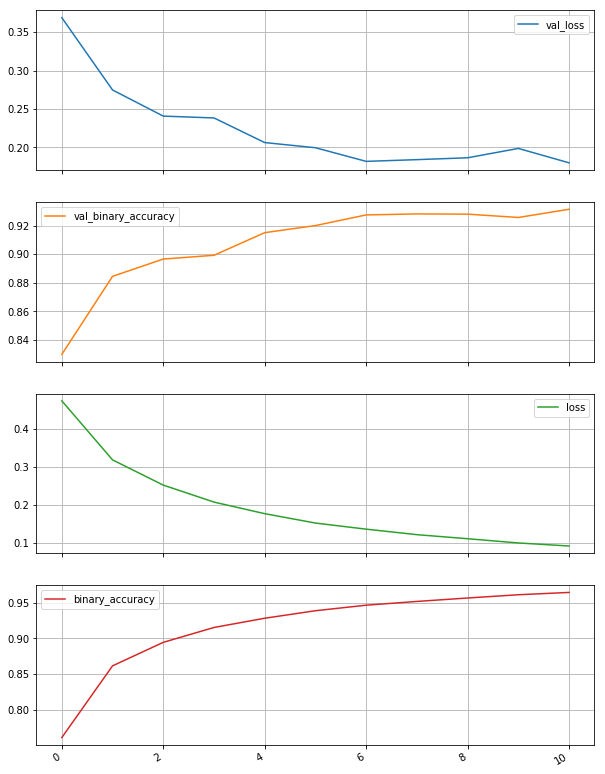

In [30]:
%matplotlib inline
df = pd.DataFrame(model_hist.history)
df.plot(subplots=True, grid=True, figsize=(10,15))


In [31]:
y = model.predict(np.array(test.iloc[:,0:len(test.columns)-1]))
predicted = np.around(y,0)

In [32]:
confusion_matrix(to_categorical(test['target'].values).argmax(axis=1), predicted.argmax(axis=1))

array([[6737,  416],
       [ 530, 6624]])

In [24]:
y = model.predict(np.array(train.iloc[:,0:len(train.columns)-1]))
predicted = np.around(y,0)
confusion_matrix(to_categorical(train['target'].values).argmax(axis=1), predicted.argmax(axis=1))

array([[63955,   423],
       [  429, 63948]])